<a href="https://colab.research.google.com/github/sean-otoole/2p_neural_activity_otoole_2023/blob/main/initial_prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# "A multi-omics atlas of the human retina at single-cell resolution"

# paper is here: "https://www.cell.com/cell-genomics/fulltext/S2666-979X(23)00064-2?uuid=uuid%3Aa0fcdee4-5bad-4a3b-9859-cc18ffabab6b"
# locaiton of the 250k RNA seq data: https://cellxgene.cziscience.com/collections/af893e86-8e9f-41f1-a474-ef05359b1fb7
# location of the atac data: https://cells.ucsc.edu/?ds=retina-atac


# "Single Cell Multiome Atlas of the Human Fetal Retina"

# from here: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE268630

In [1]:
!pip install scanpy anndata umap-learn python-igraph louvain h5py leidenalg > /dev/null 2>&1

In [2]:
import os

from google.colab import drive
drive.mount('/content/drive')

os.chdir("/content/drive/MyDrive/iob_interview_prep")

!pwd

Mounted at /content/drive
/content/drive/MyDrive/iob_interview_prep


In [3]:
# Core scverse libraries
import scanpy as sc
import anndata as ad

In [4]:
!ls

human_retina_atac.peaks.h5ad  multiomics_data
human_retina.h5ad	      processed_adult_retina.h5ad


In [5]:
# copies to the content drive to works faster

# %cp /content/drive/MyDrive/iob_interview_prep/human_retina.h5ad /content/
# ret = sc.read_h5ad('/content/human_retina.h5ad')


In [6]:
ret = sc.read_h5ad('/content/drive/MyDrive/iob_interview_prep/human_retina.h5ad')

In [8]:
# incase of mistakes in the filtering or other steps
ret.layers['counts'] = ret.X.copy()

In [18]:
import numpy as np

test = ret.X[0]
test = test.toarray()
test

array([[0.  , 0.  , 0.  , ..., 0.65, 0.05, 1.83]], dtype=float32)

In [ ]:
set(ret.obs['development_stage'].tolist())

In [ ]:
!pip install pybiomart

from pybiomart import Server

# Connect to the Ensembl Biomart server
server = Server(host='http://www.ensembl.org')

# Access Homo sapiens dataset
dataset = server.marts['ENSEMBL_MART_ENSEMBL'] \
                .datasets['hsapiens_gene_ensembl']

# Query Ensembl Gene ID and HGNC symbol
annot = dataset.query(attributes=['ensembl_gene_id', 'hgnc_symbol'])

# Rename columns for convenience (optional)
annot.columns = ["ensembl_gene_id", "hgnc_symbol"]

# Create dictionary mapping
gene_mapping = annot.set_index("ensembl_gene_id")["hgnc_symbol"].to_dict()

# Example lookup
print(gene_mapping.get("ENSG00000139618"))  # Should print 'BRCA2' or similar

In [ ]:
ret.var['feature_name']

In [ ]:
# calculate standard quality control metrics

# mitochondrial genes, "MT-" for human, "Mt-" for mouse
ret.var["mt"] = ret.var['feature_name'].str.startswith("MT-")
# ribosomal genes
ret.var["ribo"] = ret.var['feature_name'].str.startswith(("RPS", "RPL"))

In [ ]:
sc.pp.calculate_qc_metrics(
    ret, qc_vars=["mt", "ribo"], inplace=True, log1p=True
)

In [ ]:
ret = ret[ret.obs['total_counts'] < 10000]

# plot the qc metrics

sc.pl.violin(
    ret,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt","pct_counts_ribo"],
    jitter=0.4,
    stripplot=False,
    multi_panel=True,
    # groupby="disease__ontology_label"
)

In [ ]:
sc.pl.scatter(ret, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [ ]:
sc.pp.normalize_total(ret, target_sum=1e4)

In [ ]:
## these are trememdeously slow

# sc.pp.filter_cells(ret, min_genes=100)
# sc.pp.filter_genes(ret, min_cells=100)

In [ ]:
# normalizes data range
# makes the data more gaussian like
# reduces the impact of highly expressed genes
sc.pp.log1p(ret)
sc.pp.highly_variable_genes(ret, n_top_genes=3000, n_bins=100)

In [ ]:
# batch correction is required

sc.pp.combat(ret, key='donor_id')

In [ ]:
# now plot it
sc.pl.highly_variable_genes(ret)

In [ ]:
#reduce the dimesnionality
# and check for an elbow on the variance plot

sc.tl.pca(ret)
sc.pl.pca_variance_ratio(ret, n_pcs=50, log=True)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get variance ratio
var_exp = ret.uns['pca']['variance_ratio'][:50]  # First 50 PCs
cum_var_exp = np.cumsum(var_exp)

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(range(1, 51), var_exp * 100, label='Individual PC')
ax.plot(range(1, 51), cum_var_exp * 100, c='red', marker='o', label='Cumulative')

ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance (%)')
ax.set_title('Explained Variance by PCA Components')
ax.axhline(90, linestyle='--', color='gray', label='90% Threshold')
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

# Variance explained by each PC
var_exp = ret.uns['pca']['variance_ratio']

# Cumulative variance
cum_var_exp = np.cumsum(var_exp)

# Find the number of PCs that explain at least 90% of the variance
n_pcs_90 = np.argmax(cum_var_exp >= 0.90) + 1  # +1 because Python is 0-indexed

print(f"Number of PCs to explain 90% of variance: {n_pcs_90}")

In [ ]:
ret.uns['pca']['variance_ratio']

In [ ]:
# conctruct the neighborhood graph
sc.pp.neighbors(ret)

In [ ]:
# umap calculations
sc.tl.umap(ret)

In [ ]:
# plot the umap

sc.pl.umap(
    ret,
    size=2,
)

In [ ]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(ret, flavor="igraph", n_iterations=2)

In [ ]:
sc.pl.umap(ret, color=["leiden"])
sc.pl.umap(ret, color=["donor_id"])

In [ ]:
# saving the processed adata for use later
fn = "/content/drive/MyDrive/iob_interview_prep/processed_adult_retina.h5ad"

ret.write_h5ad(fn,compression='gzip')

In [5]:
fn = "/content/drive/MyDrive/iob_interview_prep/processed_adult_retina.h5ad"

ret = sc.read_h5ad(fn)

ret

AnnData object with n_obs × n_vars = 244469 × 3000
    obs: 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'suspension_enriched_cell_types', 'suspension_enrichment_factors', 'suspension_uuid', 'suspension_type', 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'sex_ontology_term_id', 'group', 'n_counts', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_c

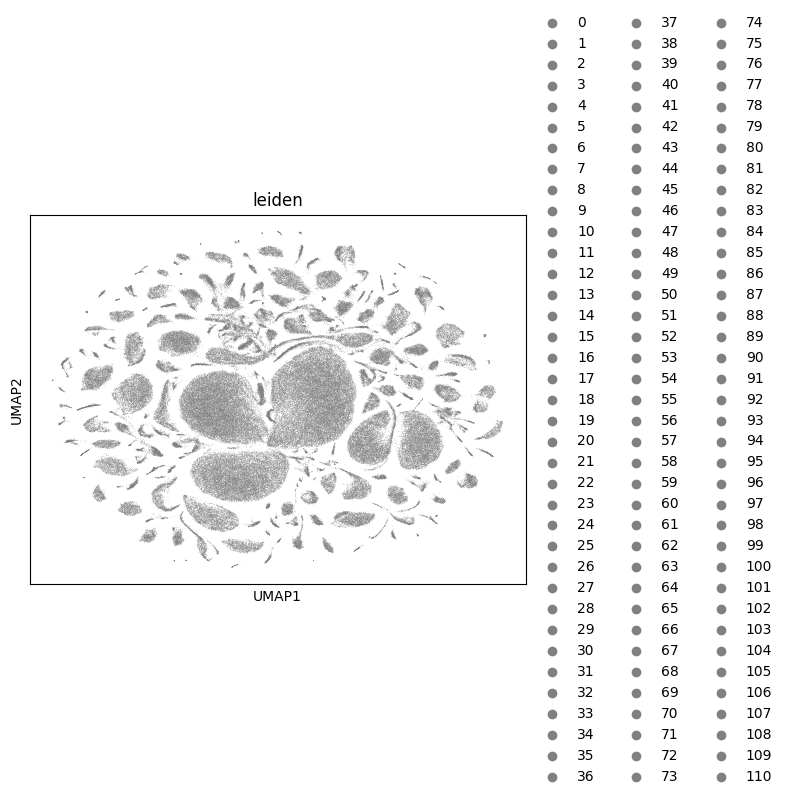

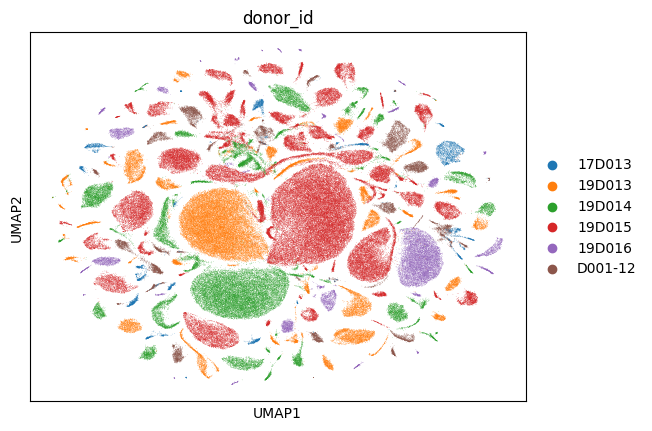

In [6]:
sc.pl.umap(ret, color=["leiden"])
sc.pl.umap(ret, color=["donor_id"])

In [8]:
ret.X.shape

(244469, 3000)

In [11]:
ret.layers['full_expr'].shape

(244469, 3000)

In [12]:
sc.pp.combat(ret, key='donor_id')

/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_combat.py:343: RuntimeWarning: divide by zero encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


In [14]:
ret.X

array([[ 3.65195308e-03,  9.94009316e-02,  3.08899868e-02, ...,
         8.04784082e-05,  7.08571171e-02,  4.42840300e-03],
       [ 3.65195308e-03,  1.27913523e-01,  3.13473037e-02, ...,
         8.04784082e-05,  7.12179167e-02,  4.42840300e-03],
       [ 3.65195308e-03,  1.27137825e-01,  3.09647265e-02, ...,
         8.04784082e-05,  7.09160829e-02,  4.42840300e-03],
       ...,
       [-1.65884695e-02,  7.29673946e-03,  3.18639623e-03, ...,
        -1.78666153e-05,  2.50712307e-02, -3.53554816e-03],
       [-1.65884695e-02,  8.55440635e-03,  3.64076316e-02, ...,
        -1.78666153e-05,  2.64218955e-02, -3.53554816e-03],
       [ 3.39027165e-01,  6.35928150e-01,  3.18639623e-03, ...,
        -1.78666153e-05,  1.31401771e+00,  5.75113918e-02]])

In [16]:
print('test')

test


In [19]:
ret

AnnData object with n_obs × n_vars = 244474 × 30867
    obs: 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'suspension_enriched_cell_types', 'suspension_enrichment_factors', 'suspension_uuid', 'suspension_type', 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'sex_ontology_term_id', 'group', 'n_counts', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'citation', 'default_embedding', 'schema_reference', 'schema_version', 'title'
    obsm: 'LVG_embedding', 'X_umap', 'cluster_memberships', 'embeddin

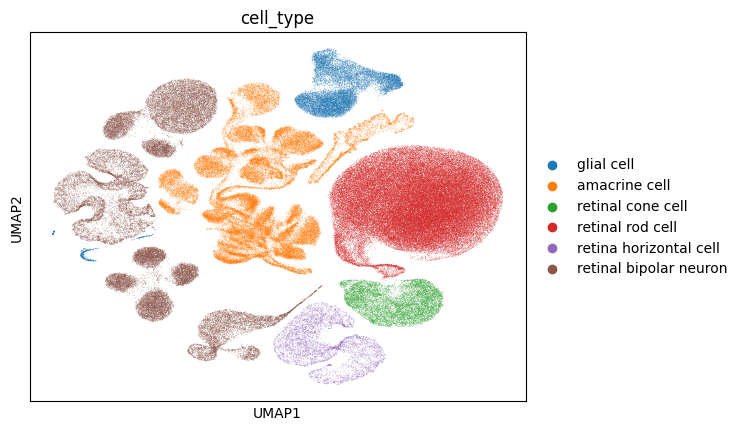

In [22]:
sc.pl.umap(ret, color=["cell_type"])

In [23]:
ret.shape

(244474, 30867)